In [14]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
data_path = "./yelp_reviews.csv" # Path to the Yelp reviews dataset. If this is an error, replace with "../yelp_reviews.csv" or copy relative path. 
df = pd.read_csv(data_path, lines=True)
# Ignore 3 star reviews for neutral sentiments
df = df[df['stars'] != 3]
df['label'] = (df['stars'] >= 4).astype(int)
df = df[:100000]
print(df.head(5))

                review_id                 user_id             business_id  \
0  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   

   stars  useful  funny  cool  \
0      5       1      0     1   

                                                text                date  \
0  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18   

   label  
0      1  



Evaluating threshold: -0.6
Accuracy: 0.8433, Precision: 0.8369, Recall: 0.9945, F1-Score: 0.9089

Evaluating threshold: -0.5
Accuracy: 0.8514, Precision: 0.8453, Recall: 0.9924, F1-Score: 0.9130

Evaluating threshold: -0.4
Accuracy: 0.8579, Precision: 0.8528, Recall: 0.9902, F1-Score: 0.9164

Evaluating threshold: -0.3
Accuracy: 0.8631, Precision: 0.8590, Recall: 0.9880, F1-Score: 0.9190

Evaluating threshold: -0.2
Accuracy: 0.8675, Precision: 0.8648, Recall: 0.9854, F1-Score: 0.9212

Evaluating threshold: -0.1
Accuracy: 0.8709, Precision: 0.8697, Recall: 0.9829, F1-Score: 0.9229

Evaluating threshold: -0.05
Accuracy: 0.8720, Precision: 0.8714, Recall: 0.9821, F1-Score: 0.9234

Evaluating threshold: 0.0
Accuracy: 0.8734, Precision: 0.8732, Recall: 0.9814, F1-Score: 0.9242

Evaluating threshold: 0.05
Accuracy: 0.8748, Precision: 0.8778, Recall: 0.9766, F1-Score: 0.9246

Evaluating threshold: 0.1
Accuracy: 0.8758, Precision: 0.8799, Recall: 0.9750, F1-Score: 0.9250

Evaluating threshold

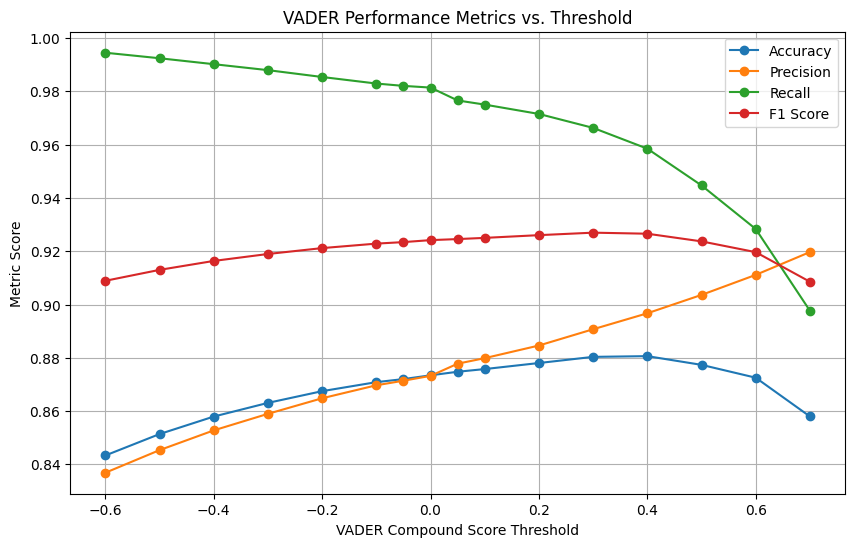


Best threshold based on F1-Score: 0.3


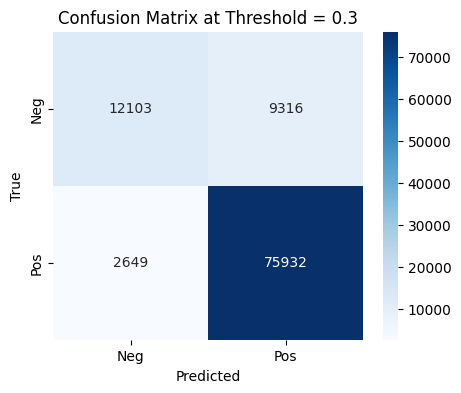


Sample discrepancies:
                review_id  stars  sentiment_rating  discrepancy
0  BiTunyQ73aT9WBnpR9DZGw      5                 5            0
1  AqPFMleE6RsU23_auESxiA      5                 5            0
2  Sx8TMOWLNuJBWer-0pcmoA      4                 5           -1
3  JrIxlS1TzJ-iCu79ul40cQ      1                 5           -4
4  6AxgBCNX_PNTOxmbRSwcKQ      5                 5            0
5  _ZeMknuYdlQcUqng_Im3yg      5                 5            0
6  rGQRf8UafX7OTlMNN19I8A      5                 5            0
7  l3Wk_mvAog6XANIuGQ9C7Q      4                 5           -1
8  XW_LfMv0fV21l9c6xQd_lw      4                 5           -1
9  8JFGBuHMoiNDyfcxuWNtrA      4                 5           -1


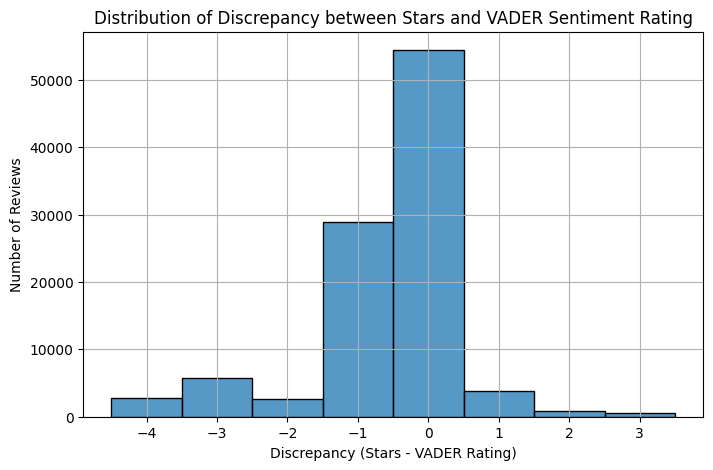

In [19]:
sia = SentimentIntensityAnalyzer()
df['compound_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Threshold tuning
thresholds = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.05, 
              0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for threshold in thresholds:
    print(f"\nEvaluating threshold: {threshold}")
    
    # predict sentiment label
    df['vader_pred_label'] = (df['compound_score'] >= threshold).astype(int)

    # classification metrics
    report = precision_recall_fscore_support(df['label'], df['vader_pred_label'], average='binary')
    accuracy = accuracy_score(df['label'], df['vader_pred_label'])
    
    print(f"Accuracy: {accuracy:.4f}, Precision: {report[0]:.4f}, Recall: {report[1]:.4f}, F1-Score: {report[2]:.4f}")

    results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': report[0],
        'recall': report[1],
        'f1': report[2]
    })

results_df = pd.DataFrame(results)

# performance metrics vs thresholds
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['threshold'], results_df['precision'], marker='o', label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], marker='o', label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], marker='o', label='F1 Score')

plt.xlabel('VADER Compound Score Threshold')
plt.ylabel('Metric Score')
plt.title('VADER Performance Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# select best threshold based on maximum F1-score
best_threshold = results_df.iloc[results_df['f1'].idxmax()]['threshold']
print(f"\nBest threshold based on F1-Score: {best_threshold}")

# confusion matrix at best threshold
df['vader_pred_label'] = (df['compound_score'] >= best_threshold).astype(int)
cm = confusion_matrix(df['label'], df['vader_pred_label'])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix at Threshold = {best_threshold}")
plt.show()

# Discrepancy analysis based on review star rating vs. VADER sentiment label
def map_score(compound_score):
    if compound_score >= 0.6:
        return 5
    elif compound_score >= 0.2:
        return 4
    elif compound_score >= -0.2:
        return 3
    elif compound_score >= -0.6:
        return 2
    else:
        return 1

df['sentiment_rating'] = df['compound_score'].apply(map_score)
df['discrepancy'] = df['stars'] - df['sentiment_rating']

print("\nSample discrepancies:")
print(df[['review_id', 'stars', 'sentiment_rating', 'discrepancy']].head(10))

# Create histogram based on discrepancy
plt.figure(figsize=(8,5))
sns.histplot(df['discrepancy'], bins=np.arange(-4,5)-0.5, kde=False)
plt.title("Distribution of Discrepancy between Stars and VADER Sentiment Rating")
plt.xlabel("Discrepancy (Stars - VADER Rating)")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

In [26]:
# print the reviews text and star ratings that have -4 discrepancy
print("\nReviews with -4 discrepancy:")
df_neg_4 = df[df['discrepancy'] == -4][['stars', 'sentiment_rating', 'text']]
print(df_neg_4['text'].head(5))



Reviews with -4 discrepancy:
3      I am a long term frequent customer of this est...
40     If you want to pay for everything a la carte t...
106    We stayed at The Saint last year for a girl's ...
206    I had a horrible experience here. The waiter w...
222    Pretty slow service and the waitresses aren't ...
Name: text, dtype: object
